## **Sistemas de Recomendación**

In [1]:
# Librerías y dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Carga de datos**

In [2]:
# Dataset
data = pd.read_csv('https://raw.githubusercontent.com/jorge-robledo11/Datasets/main/Datasets/ml-100k/u.data.csv', header=None, sep='\t')
data.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### **Limpieza**

In [3]:
# Arreglo de las cabeceras del dataset
header = ['User ID', 'Item ID', 'Rating', 'Timestamp']
data.columns = header
data.head()

,User ID,Item ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# Información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   User ID    100000 non-null  int64
 1   Item ID    100000 non-null  int64
 2   Rating     100000 non-null  int64
 3   Timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
# Datos faltantes
data.isnull().sum()

User ID      0
Item ID      0
Rating       0
Timestamp    0
dtype: int64

In [6]:
# Tipos de datos
data.dtypes

User ID      int64
Item ID      int64
Rating       int64
Timestamp    int64
dtype: object

### **Análisis exploratorio de los datos**

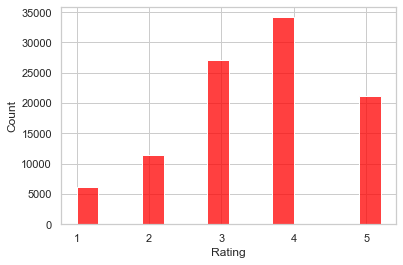

In [7]:
# Visualización del Rating
sns.set_theme(style='whitegrid')
sns.histplot(data=data, x=data.Rating, bins='auto', binwidth=0.3, color='red', legend=True)
plt.tight_layout;

La frecuencia que obtuvo cada valoración de la película

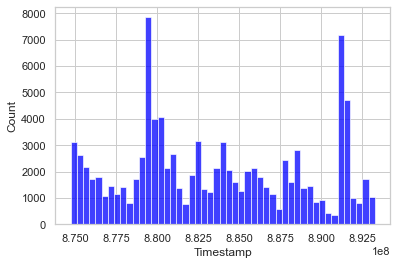

In [8]:
# Visualización del Timestamp
sns.set_theme(style='whitegrid')
sns.histplot(data=data, x=data.Timestamp, bins='auto', color='blue', legend=True)
plt.tight_layout;

In [9]:
# Agrupamos los datos para conocer algunos insights
data.groupby(['Rating'])['User ID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: User ID, dtype: int64

Los resultados de la valoración dada por los usuarios a cada película

In [10]:
# Para observar las cantidades de películas por Item ID
data['Item ID'].value_counts().sort_index(ascending=True).head(10)

1     452
2     131
3      90
4     209
5      86
6      26
7     392
8     219
9     299
10     89
Name: Item ID, dtype: int64

### **Representanción en forma matricial**

In [11]:
# Número de único de usuarios
n_users = data['User ID'].unique().shape[0]
n_users

943

In [12]:
# Número de único de películas
n_items = data['Item ID'].unique().shape[0]
n_items

1682

In [13]:
# La Matriz de Rating obtenida entre usuarios y películas
ratings = np.zeros((n_users, n_items))
print(ratings)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
# Creamos la Matriz de Ratings final
for row in data.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

ratings.shape

(943, 1682)

In [15]:
# Matriz de Ratings
print(ratings)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


In [16]:
# Coeficiente de esparseidad
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de esparseidad: {:4.2f}%".format(sparsity))

Coeficiente de esparseidad: 6.30%


## **Crear conjuntos de entrenamiento y de prueba**

In [17]:
"""
1. Hacemos Cross Validation a nuestros datos de entrenamiento y test por medio de K-Fold
2. Printeamos para ver los resultados
"""

from sklearn.model_selection import KFold

ratings = pd.DataFrame(ratings)
ratings

kf = KFold(n_splits=5, shuffle=True, random_state=0)

for train, test in kf.split(X=ratings):

    X_train = ratings.iloc[train]
    X_test = ratings.iloc[test]


print(X_train.shape)
print(X_test.shape)

(755, 1682)
(188, 1682)


In [18]:
"""
1. Importamos de la librería Scikit-learn las distancias del Coseno
2. Creamos la Matriz de Singularidad y le pasamos los datos de entrenamiento
3. Observamos la Matriz de Singularidad con los datos de entrenamiento
"""

from sklearn.metrics.pairwise import cosine_distances

# Matriz de similaridad
matriz_similaridad = 1 - cosine_distances(X_test)
print(matriz_similaridad)

[[1.         0.2202542  0.17047656 ... 0.06547048 0.32164012 0.13414107]
 [0.2202542  1.         0.17817416 ... 0.03700963 0.29677384 0.22335708]
 [0.17047656 0.17817416 1.         ... 0.00771517 0.1855371  0.27225539]
 ...
 [0.06547048 0.03700963 0.00771517 ... 1.         0.08970741 0.05291022]
 [0.32164012 0.29677384 0.1855371  ... 0.08970741 1.         0.21244437]
 [0.13414107 0.22335708 0.27225539 ... 0.05291022 0.21244437 1.        ]]


In [19]:
# Predicción de usuarios
y_pred = matriz_similaridad.dot(X_test) / np.array([np.abs(matriz_similaridad).sum(axis=1)]).T
print('La predicción de usuarios con los datos de test es:')
print(y_pred)

La predicción de usuarios con los datos de test es:
[[2.41249196 0.80978839 0.36505262 ... 0.         0.         0.        ]
 [2.55713202 0.89531648 0.38232009 ... 0.         0.         0.        ]
 [2.72465832 0.83555455 0.38147585 ... 0.         0.         0.        ]
 ...
 [1.39267862 0.26857895 0.2138568  ... 0.         0.         0.        ]
 [2.56976361 0.788943   0.35084231 ... 0.         0.         0.        ]
 [2.87237742 0.92129887 0.43813105 ... 0.         0.         0.        ]]


In [20]:
# Métricas
from sklearn.metrics import mean_squared_error

X_train = np.array(X_train)
X_test = np.array(X_test)

# Función para obtener el MSE
def get_mse(preds, actuals):

    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    
    return mean_squared_error(preds, actuals)

## **Evaluación**

In [21]:
# MSE
mse = get_mse(y_pred, X_test)
print('MSE con los datos de test es igual a', round(mse, 2))

MSE con los datos de test es igual a 7.35


In [22]:
# Evitamos la notación científica y rendondeamos los valores a 2 dígitos después de la coma
pd.options.display.float_format = '{:,.2f}'.format

# Resultados de las valoraciones
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,2.41,0.81,0.37,1.45,0.43,0.09,2.05,1.51,1.73,0.40,...,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,2.56,0.90,0.38,1.56,0.43,0.09,1.96,1.53,1.57,0.30,...,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,2.72,0.84,0.38,1.30,0.41,0.06,1.95,1.39,1.44,0.26,...,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
3,2.41,0.71,0.39,1.23,0.42,0.10,2.04,1.42,1.76,0.30,...,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,1.64,0.46,0.25,0.79,0.30,0.04,1.27,0.86,1.17,0.23,...,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00


In [23]:
# Exportamos nuestros resultados a un CSV
y_pred.to_csv(r'D:\Python Scripts & Notebooks\Jupyter Notebooks\Artificial Intelligence\Machine Learning\Proyectos de Machine Learning\resultados.csv', index=False)